In [84]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader,random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

In [3]:
# path configuration
LABELS_PATH = '../data/train_val_annotation/train_val_videodatainfo.json'
DATA_PATH = '../data/train_val_features/'

In [30]:
import json
from pickle import dump, load

In [5]:
# JSON file
f = open (LABELS_PATH, "r")
  # Reading from file
data = json.loads(f.read())

In [96]:
data['videos'][0]

{'category': 9,
 'url': 'https://www.youtube.com/watch?v=9lZi22qLlEo',
 'video_id': 'video0',
 'start time': 137.72,
 'end time': 149.44,
 'split': 'train',
 'id': 0}

In [7]:
## randomly select sentence
#label_df = pd.DataFrame(data['sentences'])
#label_final_df = label_df.groupby('video_id')['sen_id'].unique().apply(lambda x: x[np.random.randint(0,20)]).to_frame().reset_index()
#label_final_df['video_id'].nunique()
#label_final_df = label_final_df.join(label_df[['sen_id', 'caption']].set_index('sen_id'), on='sen_id')
#label_final_df.to_csv('../data/label_final.csv', index=False)

## DataSet

In [8]:
label_final_df = pd.read_csv('../data/label_final.csv')

### 1. Create embedding matrix from google news word2vec

In [9]:
import spacy
from collections import Counter
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [35]:
# embedding
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))
glove_emb = gensim.downloader.load('word2vec-google-news-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [11]:
all_sent = label_final_df['caption'].tolist()#.astype('unicode')

In [26]:
wc = Counter()
try:
    for doc in nlp.pipe(all_sent):
        for word in doc:
            #print(word)
            wc[str(word)] += 1
except Exception as e:
    print(e)
    print(doc,'\nword:', word)

In [51]:
# create embedding matrix
# initialization
EMBEDDING_SIZE = 300
embedding = np.zeros((len(wc)+4, 300)) # +4 for start, end, unk, padding
word2idx = {}
idx2word = {}

word2idx['<PAD>'] = 0
idx2word[0] = '<PAD>'
embedding[0] = np.random.rand(300)*2 - 1

word2idx['<START>'] = 1
idx2word[1] = '<START>'
embedding[1] = np.random.rand(300)*2 - 1

word2idx['<END>'] = 2
idx2word[2] = '<END>'
embedding[2] = np.random.rand(300)*2 - 1

word2idx['<UNK>'] = 3
idx2word[3] = '<UNK>'
embedding[3] = np.random.rand(300)*2 - 1

count = 0
for word, _ in wc.most_common():
    wid = len(word2idx)
    word2idx[word] = wid
    idx2word[wid] = word
    if word in glove_emb:
        embedding[wid] = glove_emb.get_vector(word)
    else:
        embedding[wid] = np.random.rand(300)*2 - 1 # random initialisation (-1, 1)
        count += 1

In [53]:
print(f'{count} words are not in google news werd2vec')

401 words are not in google news werd2vec


In [835]:
np.save('../model/embedding.npy', embedding)

In [988]:
import pickle
with open("../model/word2idx.pkl","wb") as f:
    pickle.dump(word2idx, f)


In [989]:
with open("../model/idx2word.pkl","wb") as f:
    pickle.dump(idx2word, f)

### 2.Dataset Class for pytorch

In [279]:
class MSRVTT(Dataset):
    def __init__(self, df, word2idx, DATA_PATH):
        super(MSRVTT, self).__init__()
        self.df = df
        self.path = DATA_PATH
        self.word2idx = word2idx
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vid = row['video_id']
        filename = self.path + f'{vid}-feature.pt5'
        x = torch.load(filename)
        sentence_emb = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in row['caption'].split(' ')]
        y = torch.zeros(len(sentence_emb)+2)
        y[0], y[-1] = self.word2idx['<START>'], self.word2idx['<END>']
        y[1:-1] = torch.tensor(sentence_emb)
        #true_sentence = row['caption']
        return x, y.long()#, true_sentence

In [280]:
ds = MSRVTT(label_final_df, word2idx, DATA_PATH)

In [282]:
ds_iter = iter(ds)

In [285]:
x.size(0)

30

In [286]:
frames_size = []
sents_length = []
for x, y in ds_iter:
    frames_size.append(x.size(0))
    sents_length.append(len(y))

In [291]:
import matplotlib.pyplot as plt

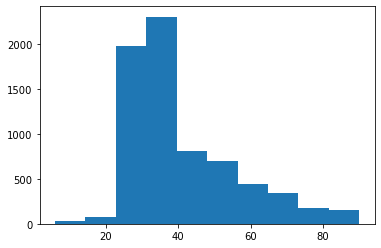

In [293]:
# frames length distribution
plt.hist(frames_size)
plt.show()

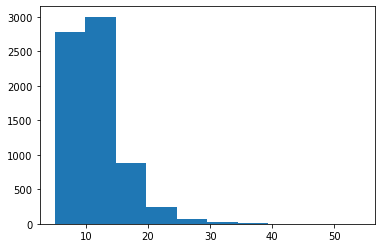

In [295]:
# sentence length distribution
plt.hist(sents_length)
plt.show()

### 3.Dataloaders

In [428]:
def collate_fn(batch):
    """
    padding  text or video
    """
    x_batch = []
    y_batch = []
    for x, y in batch:
        x_batch.append(x)
        y_batch.append(y)
    lengths = list(map(lambda x: x.size(0), x_batch))
    x_batch = torch.nn.utils.rnn.pad_sequence(x_batch,  batch_first=True)
    x_batch = torch.nn.utils.rnn.pack_padded_sequence(x_batch, lengths, batch_first=True, enforce_sorted=False)
    y_batch = torch.nn.utils.rnn.pad_sequence(y_batch, batch_first=True)
    return x_batch, y_batch#, lengths  # PackedSequence, padded tensor

#torch.nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=False, enforce_sorted=True)

In [429]:
# split train/test
train_proportion = 0.93
train_size = int(train_proportion * len(ds))
validation_size = len(ds) - train_size
print(train_size, validation_size)

6519 491


In [733]:
train_ds, validation_ds = random_split(ds, [train_size, validation_size])
# dataloaders
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
valid_dl = DataLoader(validation_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [734]:
x, y = next(iter(train_dl))

In [197]:
x.data.size()

torch.Size([370, 2048])

# Model

### Sequence to Sequence Model (Encoder-Decoder)

While image description handles a variable length output sequence of words, video description also has to handle a variable length input sequence of frames. Related approaches to video description have resolved variable length input by holistic video representations [29, 28, 11], pooling over frames [39], or sub-sampling on a fixed number of input frames [43]. In contrast, in this work we propose a sequence to sequence

#### Questions for the input data:
1. I tried the following code with x.data as well, but the it losts information for the batch size, in this case it is 8.
2. The input dim is 2, while conv2d in the pretrained model neeeds data to be 4-dim, even conv1d needs dim-3 data.

In [200]:
# from torchvision.models import resnet18, resnet101

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        
        self.densenet = models.densenet121(pretrained=True)
        
        self.densenet.classifier = nn.Linear(in_features=1024, out_features=1024)
        
        # add another fully connected layer
        self.embed = nn.Linear(in_features=1024, out_features=hidden_dim)
        
        # dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
        # activation layers
        self.prelu = nn.PReLU()
        
    def forward(self, x):
        
        # get the embeddings from the densenet
        densenet_outputs = self.dropout(self.prelu(self.densenet(x)))
        
        # pass through the fully connected
        embeddings = self.embed(densenet_outputs)
        
        return embeddings
    
class Decoder(nn.Module):
    '''
    Decode Hidden State from Encoder to sentence (sequence of texts)
    
    note: batch_first=True does not apply to hidden or cell states
    '''
    def __init__(self, weights, emb_dim, hidden_dim, out_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.out_dim = out_dim
        
        # layers
        self.emb = nn.Embedding.from_pretrained(torch.tensor(weights), padding_idx=0, freeze=False)
        self.rnn = nn.GRU(emb_dim + hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc_out = nn.Linear(emb_dim + hidden_dim * 2, out_dim)
                
    def forward(self, word_input, encoded_context, hidden):
        '''
        word_input: (batch_size)
        encoded_context: (1, batch_size, hidden_dim)
        hidden: (1, batch_size, hidden_dim)
        '''
        # 1 word at a time
    
        word_input = self.emb(word_input) # dim (batch, emb_dim)
        print(word_input.size())
        print(encoded_context.size())
        emb_input = torch.cat([word_input, encoded_context.squeeze(0)], dim=1)
        output, hidden = self.rnn(emb_input.unsqueeze(1).float(), hidden)
        prediction = self.fc_out(torch.cat([word_input, encoded_context.squeeze(0), hidden.squeeze(0)], dim=1).float())
        return prediction, hidden 
    

In [201]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, x, y, teacher_forcing_ratio=0.8):
        '''
        x: PackedSequence
        y: (batch_size, sentence_len(padded))
        hidden: (1, batch_size, hidden_dim)
        '''
        batch_size = y.size(0)
        sentence_len = y.size(1)
        vocab_size = self.decoder.out_dim
        
        ##############
        # Initialize #
        ##############
        # tensor for final outputs
        outputs = torch.zeros(batch_size, sentence_len, vocab_size).to(self.device)
        # last hidden state of the encoder is the context
        encoded_context = self.encoder(x) # (1, batch_size, hidden_dim)
        # first hidden state 
        hidden = encoded_context # (1, batch_size, hidden_dim)
        # first input '<START>'
        word_input = y[:, 0] # (batch_size)
        for t in range(1, sentence_len):
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(word_input, encoded_context, hidden)
            
            #place predictions in a tensor holding predictions for each token
            outputs[:, t, :] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = np.random.rand() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) # dim: (batch_size)
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            word_input = y[:, t] if teacher_force else top1

        return outputs
    

# Training 

Set up the model

In [202]:
N_VOCAB = len(word2idx)
EMB_DIM = 300
INPUT_DIM = 2048 # resnet50 fc dim
HIDDEN_DIM = 800

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(INPUT_DIM, HIDDEN_DIM)
decoder = Decoder(embedding, EMB_DIM, HIDDEN_DIM, N_VOCAB)
model = Seq2Seq(encoder, decoder, device)

weight initialization with N(0, 0.01)

In [203]:
for name, param in model.named_parameters():
    if name != 'decoder.emb.weight':
        print(name, param.shape)
        nn.init.normal_(param.data, mean=0, std=0.1)

encoder.densenet.features.conv0.weight torch.Size([64, 3, 7, 7])
encoder.densenet.features.norm0.weight torch.Size([64])
encoder.densenet.features.norm0.bias torch.Size([64])
encoder.densenet.features.denseblock1.denselayer1.norm1.weight torch.Size([64])
encoder.densenet.features.denseblock1.denselayer1.norm1.bias torch.Size([64])
encoder.densenet.features.denseblock1.denselayer1.conv1.weight torch.Size([128, 64, 1, 1])
encoder.densenet.features.denseblock1.denselayer1.norm2.weight torch.Size([128])
encoder.densenet.features.denseblock1.denselayer1.norm2.bias torch.Size([128])
encoder.densenet.features.denseblock1.denselayer1.conv2.weight torch.Size([32, 128, 3, 3])
encoder.densenet.features.denseblock1.denselayer2.norm1.weight torch.Size([96])
encoder.densenet.features.denseblock1.denselayer2.norm1.bias torch.Size([96])
encoder.densenet.features.denseblock1.denselayer2.conv1.weight torch.Size([128, 96, 1, 1])
encoder.densenet.features.denseblock1.denselayer2.norm2.weight torch.Size([1

In [204]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss(ignore_index=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, threshold=0.001, threshold_mode='rel', min_lr=0)

In [205]:
def train_one_epoch(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    
    for i, (x, y) in enumerate(tqdm(dataloader)):
        
        out = model(x, y)
        out = out.view(-1, 6157)
        y = y.view(-1)
        loss = lossFun(out, y)
        
        total_loss += loss.item()
        if i % 50 == 0:
            print(f'Batch loss: {loss.item()}')
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
    
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss



def evaluate(model, dataloader, lossFun):
    
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
    
        for x, y in tqdm(dataloader):

            out = model(x, y)
            out = out.view(-1, 6157)
            y = y.view(-1)
            loss = lossFun(out, y)

            total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [206]:
# train 3 more epochs
EPOCHS = 5
best = 100000

for epoch in range(EPOCHS):
    print('Epoch: ', epoch)
    
    train_loss = train_one_epoch(model, train_dl, optimizer, loss_func)
    print('Train Loss: ', train_loss)
    
    valid_loss = evaluate(model, valid_dl, loss_func)
    print('Valid Loss: ', valid_loss)
    
    if valid_loss < best:
        best = valid_loss
        torch.save(model.state_dict(),  '../model/seq2seq_v2.pt')
    scheduler.step(valid_loss)

  0%|          | 0/815 [00:00<?, ?it/s]

Epoch:  0


TypeError: conv2d() received an invalid combination of arguments - got (PackedSequence, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mPackedSequence[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mPackedSequence[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)


In [185]:
# train 3 more epochs
EPOCHS = 10

for epoch in range(EPOCHS):
    print('Epoch: ', epoch)
    
    train_loss = train_one_epoch(model, train_dl, optimizer, loss_func)
    print('Train Loss: ', train_loss)
    
    valid_loss = evaluate(model, valid_dl, loss_func)
    print('Valid Loss: ', valid_loss)
    
    if valid_loss < best:
        best = valid_loss
        torch.save(model.state_dict(),  '../model/seq2seq_v2.pt')
    scheduler.step(valid_loss)

  0%|          | 0/815 [00:00<?, ?it/s]

Epoch:  0
encoder output torch.Size([1, 319, 2048])
torch.Size([8, 300])
torch.Size([1, 319, 2048])


RuntimeError: torch.cat(): Sizes of tensors must match except in dimension 1. Got 8 and 319 in dimension 0 (The offending index is 1)

In [1058]:
model.eval()
with torch.no_grad():
    context = model.encoder(test_x.unsqueeze(0))
context

tensor([[[ 8.3415e-07,  1.8757e-08, -1.0000e+00, -7.6159e-01,  2.7992e-12,
          -3.5686e-05,  8.0224e-15, -1.5713e-10, -1.4366e-13,  3.3050e-13,
           2.0661e-21,  1.0000e+00, -1.2542e-10, -4.9077e-11, -9.7051e-05,
           1.3208e-20,  7.0467e-07,  1.1476e-12, -1.8057e-11,  8.1142e-15,
          -3.8975e-02, -1.4302e-16, -1.0386e-09, -2.6230e-12,  7.6159e-01,
          -2.6330e-23, -1.2532e-02, -5.2528e-04, -1.2949e-07,  2.4892e-08,
           6.0026e-07, -1.1196e-10,  1.5296e-10, -5.0617e-09,  2.4082e-09,
          -3.3455e-08, -1.0477e-16,  4.9381e-16, -9.8111e-22,  1.8580e-14,
          -4.9357e-11,  1.0770e-11,  4.9214e-10,  9.3780e-16, -6.4904e-04,
           1.0489e-06,  5.5468e-14,  1.2570e-05, -5.2065e-02, -1.0022e-04,
          -1.2523e-10, -3.3691e-08,  1.9675e-05, -1.4091e-15,  1.4231e-01,
           1.4667e-12,  5.1739e-10, -5.8571e-08, -3.2723e-04,  1.1033e-10,
          -3.1379e-28, -2.8651e-10, -1.4404e-19, -9.0455e-08, -7.8566e-11,
           1.3765e-10,  4

# Model Diagnosis

In [1079]:
def gen_seq(model, x, start_token, seq_length):
    with torch.no_grad():
        word_input = torch.tensor(word2idx[start_token]).unsqueeze(0)
        context = model.encoder(x.unsqueeze(0))
        hidden = context
        outputs = [start_token]
        ## generate a sequence!
        for i in range(seq_length):
            output, hidden = model.decoder(word_input, context, hidden)
            word = output.argmax(1)
            outputs.append(idx2word[word.item()])
            word_input = word
        return outputs

In [1069]:
iterator = iter(train_ds)

In [1076]:
test_x, test_y = next(iterator)
test_x.shape

torch.Size([50, 2048])

tensor([   1,    4, 1082,   25, 5597,  104,   25,  219,    5, 2308,  305,   12,
           4,  389,    2])

In [1082]:
[idx2word[word.item()] for word in test_y]

['<START>',
 'a',
 'teenage',
 'girl',
 'teases',
 'another',
 'girl',
 'who',
 'is',
 'blindfolded',
 'next',
 'to',
 'a',
 'river',
 '<END>']

In [1078]:
gen_seq(model, test_x,  '<START>', 15)

tensor([[ 1.4117e-07,  8.7523e-09, -1.0000e+00, -7.6159e-01,  3.1522e-14,
         -3.8256e-06,  1.7946e-15, -1.5878e-11, -6.9432e-16,  2.3584e-15,
          1.6964e-22,  1.0000e+00, -2.9911e-12, -1.3260e-12, -6.8926e-03,
          1.2900e-22,  3.9233e-08,  1.9082e-13, -6.0221e-12,  3.7145e-15,
         -6.2369e-03, -7.8452e-15, -9.1389e-10, -1.4576e-13,  7.6159e-01,
         -3.6218e-25, -4.9680e-03, -2.1962e-04, -1.4119e-09, -1.8743e-08,
          6.3280e-08, -1.4303e-11,  1.7118e-11, -1.7941e-09,  1.9121e-10,
         -2.3796e-08, -3.5009e-14,  7.3931e-16, -4.8089e-22,  2.3265e-13,
         -8.8118e-11,  5.9196e-12,  6.9587e-11,  5.1894e-16, -4.3336e-06,
          1.3440e-05,  2.3725e-14,  3.2155e-04, -4.9125e-01, -4.2814e-04,
         -1.0928e-10, -4.0647e-09,  1.0124e-05, -4.2381e-17,  6.6224e-02,
          1.7039e-13,  4.5293e-11, -2.1232e-09, -5.8124e-06,  2.0353e-11,
         -5.4074e-28, -4.1671e-11,  9.0823e-21, -4.6344e-07, -4.0680e-09,
          1.1559e-11,  4.7354e-08,  2.

['<START>',
 'a',
 'man',
 'is',
 'talking',
 'about',
 'a',
 'car',
 '<END>',
 '<END>',
 'his',
 'father',
 'in',
 'a',
 'home',
 '<END>']